In [1]:
:extension TypeFamilies DerivingStrategies GeneralizedNewtypeDeriving FlexibleContexts OverloadedStrings

import Diagrams.Prelude
import Control.Monad ((>=>))
import Data.Bifunctor (second)
import Data.Tuple (swap)
import Data.String (IsString)
import Data.Maybe (fromJust)

In [2]:
newtype Location = Location String deriving newtype (Eq, Show, IsString)

newtype BellPair = BellPair (Location, Location)
instance Show BellPair where
    show (BellPair (Location l1, Location l2)) = l1 <> "," <> l2 
instance Eq BellPair where
    BellPair p == BellPair p' = p == p' || swap p == p' 

data Tree = Tree { pair :: BellPair , children :: [Tree]}

newtype History = History [Tree] deriving newtype Semigroup 

newtype Policy = Policy (History -> Maybe History)

In [3]:
findTreeRoot :: BellPair -> [Tree] -> Maybe (Tree, [Tree])
findTreeRoot p [] = Nothing
findTreeRoot p (t : ts) | pair t == p = Just (t, ts)
                        | otherwise = second (t :) <$> findTreeRoot p ts

In [4]:
create :: Location -> Policy
create l = Policy $ \h -> Just $ History [Tree (BellPair (l, l)) []] <> h

swap :: Location -> (Location, Location) -> Policy
swap l (l1, l2) = Policy $ \(History ts) -> 
    findTreeRoot (BellPair (l, l1)) ts >>= \(t, ts) ->
        findTreeRoot (BellPair (l, l2)) ts >>= \(t', ts) ->
            Just $ History $ [Tree (BellPair (l1, l2)) [t, t']] <> ts 
            
transmit :: Location -> (Location, Location) -> Policy
transmit l (l1, l2) = Policy $ \(History ts) ->
    findTreeRoot (BellPair (l, l)) ts >>= \(t, ts) ->
        Just $ History $ [Tree (BellPair (l1, l2)) [t]] <> ts
            
distill :: Location -> Location -> Policy
distill l1 l2 = Policy $ \(History ts) ->
    findTreeRoot (BellPair (l1, l2)) ts >>= \(t, ts) ->
        findTreeRoot (BellPair (l1, l2)) ts >>= \(t', ts) ->
            Just $ History $ [Tree (BellPair (l1, l2)) [t, t']] <> ts

(-*-) :: Policy -> Policy -> Policy
(Policy f) -*- (Policy g) = Policy $ f >=> g

(-+-) :: Policy -> Policy -> Policy
(Policy f) -+- (Policy g) = Policy $ \h -> (<>) <$> f h <*> g h

(-$-) :: Policy -> History -> Maybe History
(Policy f) -$- h = f h 

In [7]:
pairToDiagram bp = (text (show bp) <> rect 4 1) # fontSize (local 0.5) 
treeToDiagram t = 
    let childrenNames = [1..(length $ children t :: Int)]
        rootName = 0 :: Int
        subtrees = zipWith (.>>) childrenNames (map treeToDiagram $ children t)
      in vsep 1 [pairToDiagram (pair t) # named rootName, hsep 0.5 subtrees # centerX  ] # appEndo (mconcat $ map (\i -> Endo $ connectOutside (i .> rootName) rootName) childrenNames)
historyToDiagram (History ts) = hsep 0.5 (map treeToDiagram ts)

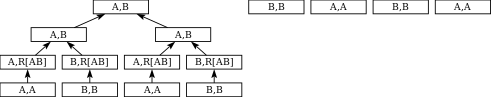

In [10]:
p = (create "A" -+- create "B") -*- (transmit "A" ("A", "R[AB]") -+- transmit "B" ("B", "R[AB]")) 
    -*- swap "R[AB]" ("A", "B")
diagram . historyToDiagram . fromJust $ (p -+- p) -*- distill "A" "B" -$- History []